## 小説家になろう ブクマ数予測 \~”伸びる”タイトルとは？\~ チュートリアル

このnotebookは、Nishikaコンペティション [小説家になろう ブクマ数予測 \~”伸びる”タイトルとは？\~](https://www.nishika.com/competitions/21/summary) のチュートリアルです。

コンペタイトルにもある通り、「小説タイトル」「小説あらすじ」といったテキストデータから得られる情報がブクマ数予測に効くか？というのが、1つのテーマです。

そこで本notebookでは、特にテキストデータからの特徴量作成に焦点を当てます。<br>
例えば、タイトルが短くまとまっている作品に良作品が多い、などの傾向があるかもしれません（「[無職転生](https://ncode.syosetu.com/n9669bk/)」「[俺は星間国家の悪徳領主！](https://ncode.syosetu.com/n1976ey/)」などが好きな私による全くの主観です）。

もちろん、精度向上には構造化データによる特徴量作成も効果的ですので、色々試してみましょう！<br>
（構造化データからの特徴量作成は、[こちらのチュートリアル](https://colab.research.google.com/drive/1uGESzJFtzbDwGSq9Jk1w4QhtrPjP5XqY?usp=sharing)などをご覧ください）

| 要素 | 説明 |
| ---- | ---- |
|ncode | Nコード|
|general_firstup | 初回掲載日 YYYY-MM-DD HH:MM:SSの形式|
|title | 小説名|
|story | 小説のあらすじ|
|keyword | キーワード|
|userid | 作者のユーザID(数値)|
|writer | 作者名|
|biggenre | 大ジャンル|
|genre | ジャンル|
|novel_type | 連載の場合は1、短編の場合は2|
|end | 短編小説と完結済小説は0となっています。連載中は1です。|
|isstop | 長期連載停止中なら1、それ以外は0です。|
|isr15 | 登録必須キーワードに「R15」が含まれる場合は1、それ以外は0です。|
|isbl | 登録必須キーワードに「ボーイズラブ」が含まれる場合は1、それ以外は0です。|
|isgl | 登録必須キーワードに「ガールズラブ」が含まれる場合は1、それ以外は0です。|
|iszankoku | 登録必須キーワードに「残酷な描写あり」が含まれる場合は1、それ以外は0です。|
|istensei | 登録必須キーワードに「異世界転生」が含まれる場合は1、それ以外は0です。|
|istenni | 登録必須キーワードに「異世界転移」が含まれる場合は1、それ以外は0です。|
|pc_or_k | 1はケータイのみ、2はPCのみ、3はPCとケータイで投稿された作品です。<br>対象は投稿と次話投稿時のみで、どの端末で執筆されたかを表すものではありません。|
|fav_novel_cnt_bin | ブックマーク度|

ページ上部の「ランタイム」>「ランタイムのタイプを変更」から「GPU」「ハイメモリ」を選択

ドライブをマウント（左側サイドバーから実行）

package install

In [ ]:
!pip install xfeat >> /dev/null
!pip install ginza ja-ginza >> /dev/null

ランタイムを再起動（再起動しないとja_ginzaのloadでエラー）

In [ ]:
import json
import pickle
import re
from glob import glob
from tqdm import tqdm

import regex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

import spacy
nlp = spacy.load('ja_ginza')

from sklearn.metrics import log_loss
from xfeat import Pipeline, SelectCategorical, LabelEncoder

### ファイル読み込み・データ確認

In [ ]:
# train.csv, test.csv, sample_submission.csvを格納しているパスを指定ください
PATH = 'drive/MyDrive/Colab Notebooks/cpt-narou/data/input'

In [ ]:
cd {PATH}

/content/drive/MyDrive/Colab Notebooks/cpt-narou/data/input


In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sub_df = pd.read_csv('sample_submission.csv')

In [ ]:
raw_df = pd.concat([train_df, test_df])
train_idx = train_df.shape[0] # 何行目までが学習データか、後ほど使う
print(raw_df.shape)
raw_df.head(2)

(48522, 20)


ncode      general_firstup  ... pc_or_k fav_novel_cnt_bin
0  N7588B  2007-04-01 16:40:57  ...       0               1.0
1  N8726B  2007-04-22 15:40:30  ...       3               2.0

[2 rows x 20 columns]

今回与えられているデータの件数は、学習用・評価用合わせて4万件強で、小説家になろうに掲載されている90万件ほどの作品の一部となっています。<br>
目的変数であるブックマーク度の分布を確認してみます。ついでに、冒頭で主観的な仮説を出したタイトル・あらすじの長さについても見てみます。

In [ ]:
TARGET = 'fav_novel_cnt_bin'

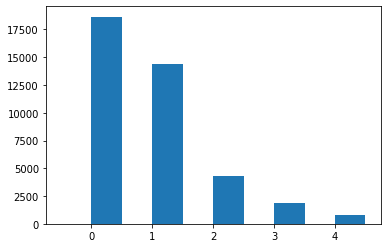

In [ ]:
# ブックマーク度の分布を確認

plt.hist(train_df[TARGET], range=(-0.5, 4.5))
plt.show()

ブックマーク度が高い（ブックマーク数が多い）作品はかなり限定的です。

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



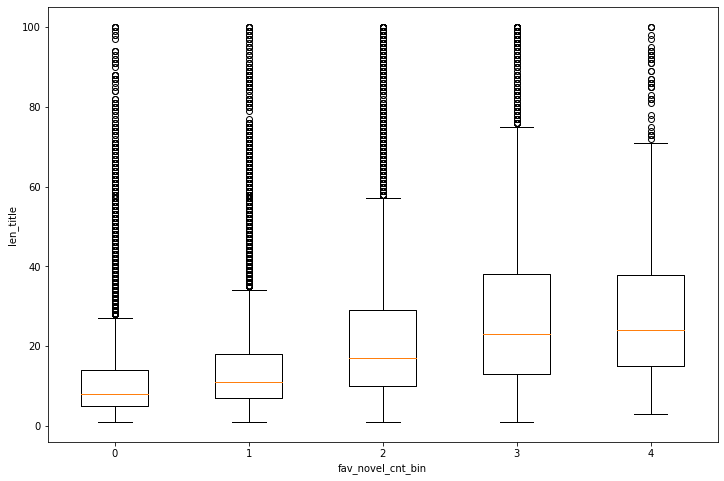

In [ ]:
# タイトルの長さとブックマーク度を箱髭図にプロット

data = []
xlabels = []

for t in sorted(train_df[TARGET].unique()):
    xlabels.append(t)
    tmp = train_df[train_df[TARGET] == t]
    data.append(tmp['title'].map(len))

plt.figure(figsize=(12, 8))
plt.boxplot(data)
plt.xlabel(TARGET)
plt.ylabel('len_title')
ax = plt.gca()
plt.setp(ax, xticklabels=xlabels)
plt.show()

タイトルが短くまとまっている方が良作品、という冒頭の仮説はそうでもないことがわかってしまいました。<br>
そう言えば、自分は[ティアムーン帝国物語　～断頭台から始まる、姫の転生逆転ストーリー～](https://ncode.syosetu.com/n8920ex/)や[悲劇の元凶となる最強外道ラスボス女王は民の為に尽くします。〜ラスボスチートと王女の権威で救える人は救いたい〜](https://ncode.syosetu.com/n0692es/)も好きなことを思い出したので、前言撤回します。

しかし、予測に有効な可能性はもちろん残っています。

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



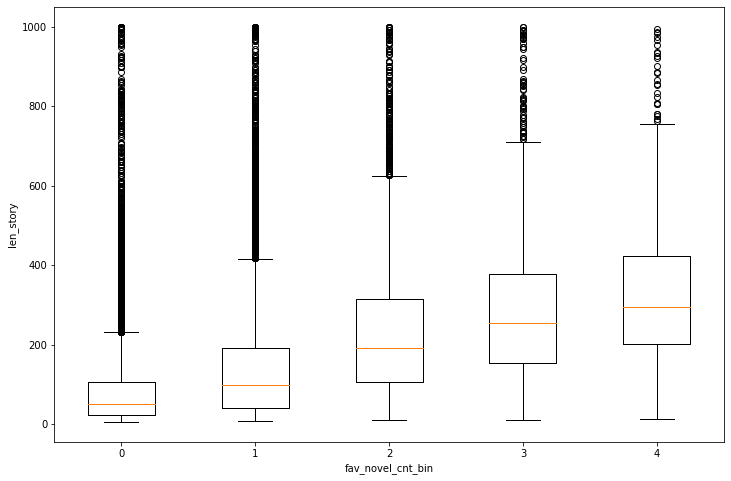

In [ ]:
# あらすじの長さとブックマーク度を箱髭図にプロット

data = []
xlabels = []

for t in sorted(train_df[TARGET].unique()):
    xlabels.append(t)
    tmp = train_df[train_df[TARGET] == t]
    data.append(tmp['story'].map(len))

plt.figure(figsize=(12, 8))
plt.boxplot(data)
plt.xlabel(TARGET)
plt.ylabel('len_story')
ax = plt.gca()
plt.setp(ax,xticklabels = xlabels)
plt.show()

あらすじの長い方がブックマーク度が高い、という関係があるようです。

### feature engineering

構造化データを使った特徴量作成については、今回はごく簡単なものにとどめます。<br>
xfeatは様々な特徴量生成が可能なライブラリですので、是非使い込んでみてください！

In [ ]:
import datetime

dt_now = datetime.datetime.now()
raw_df['past_days'] = raw_df['general_firstup'].apply(lambda x: (dt_now - datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')).days)

In [ ]:
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_df = encoder.fit_transform(raw_df)
le_df.head(2)

ncode  general_firstup  title  story  keyword  writer
0      0                0      0      0        0       0
1      1                1      1      1        1       1

In [ ]:
raw_df['writer'] = le_df['writer']

#### テキストから古典的な特徴量作成

まずは品詞ベースで形態素の数をカウント、全体に占める割合を計算した特徴量を作成します。<br>
さらに、タイトルなどに否定系の表現がどの程度入っているかも影響がありそうと考え、否定系の助動詞に絞って同様の計算をしてみます。

In [ ]:
def create_pos_features(texts):
    """品詞ベースの特徴量を作成"""

    docs = list(tqdm(nlp.pipe(texts, disable=['ner'])))

    pos_data = {}

    negative_auxs = [0]*len(docs)

    for i, doc in enumerate(docs):
        for token in doc:
            # 品詞が○○である形態素の数。後で全形態素数で割る
            if token.pos_ not in pos_data:
                pos_data[token.pos_] = [0]*len(docs)
            pos_data[token.pos_][i] += 1

            # 品詞が助動詞の「ない」「ぬ」「ん」の数。後で全形態素数で割る
            if token.pos_ == 'AUX' and token.lemma_ in ['ない', 'ぬ', 'ん']:
                negative_auxs[i] += 1

    pos_df = pd.DataFrame.from_dict(pos_data, orient='index').T
    pos_df['num_token'] = pos_df.sum(axis=1) # 全形態素数

    pos_df['NEG_AUX'] = negative_auxs

    for colname in pos_df.columns:
        if colname != 'num_token':
            pos_df[colname] /= pos_df['num_token'] # 全形態素数で割る

    return pos_df

単純なテキストの長さとともに、ひらがなやカタカナ、漢字、絵文字などがどの程度含まれるか、も何らか影響があるかもしれません。<br>
文字種別に文字数をカウントし、特徴量としてみます。

In [ ]:
def create_type_features(texts):
    """文字種ベースの特徴量を作成"""

    type_data = []

    for text in texts:
        tmp = []
        
        tmp.append(len(text))

        # 平仮名の文字数カウント
        p = re.compile('[\u3041-\u309F]+')
        s = ''.join(p.findall(text))
        tmp.append(len(s))

        # カタカナの文字数カウント
        p = re.compile('[\u30A1-\u30FF]+')
        s = ''.join(p.findall(text))
        tmp.append(len(s))

        # 漢字の文字数カウント
        p = regex.compile(r'\p{Script=Han}+')
        s = ''.join(p.findall(text))
        tmp.append(len(s))

        # 絵文字の文字数カウント
        p = regex.compile(r'\p{Emoji_Presentation=Yes}+')
        s = ''.join(p.findall(text))
        tmp.append(len(s))

        type_data.append(tmp)

    colnames = ['length', 'hiragana_length', 'katakana_length', 'kanji_length', 'emoji_length']
    type_df = pd.DataFrame(type_data, columns=colnames)

    for colname in type_df.columns:
        if colname != 'length':
            type_df[colname] /= type_df['length']

    return type_df

まずタイトルに対して処理

In [ ]:
titles = raw_df['title'].values
docs = list(nlp.pipe(titles, disable=['ner']))

In [ ]:
title_pos_df = create_pos_features(titles)
title_pos_df.columns = ['title_' + colname for colname in title_pos_df.columns]

48522it [03:23, 238.04it/s]


In [ ]:
title_type_df = create_type_features(titles)
title_type_df.columns = ['title_' + colname for colname in title_type_df.columns]

次にあらすじに対して処理

In [ ]:
stories = raw_df['story'].values

In [ ]:
# かなり大きなメモリを使用するので、念の為データを分割しバッチ処理

nrow_one_loop = 20000
nloop = np.floor(len(stories)/nrow_one_loop)
min_idx = 0

story_pos_dfs = []

while min_idx < len(stories):
    tmp_stories = stories[min_idx:min_idx+nrow_one_loop]
    suffix = str(min_idx//nrow_one_loop) if len(str(min_idx//nrow_one_loop)) != 1 else '0'+str(min_idx//nrow_one_loop)
    story_pos_dfs.append(create_pos_features(tmp_stories))
    min_idx += nrow_one_loop

20000it [10:31, 31.66it/s] 
20000it [07:58, 41.78it/s] 
8522it [02:52, 49.33it/s]


In [ ]:
story_pos_df = pd.concat(story_pos_dfs)
del story_pos_dfs

In [ ]:
# かなり大きなメモリを使用するので、念の為データを分割しバッチ処理

nrow_one_loop = 20000
nloop = np.floor(len(stories)/nrow_one_loop)
min_idx = 0

story_type_dfs = []

while min_idx < len(stories):
    tmp_stories = stories[min_idx:min_idx+nrow_one_loop]
    story_type_dfs.append(create_type_features(tmp_stories))
    min_idx += nrow_one_loop

In [ ]:
story_type_df = pd.concat(story_type_dfs)
del story_type_dfs

#### BERTVectorizer

上では古典的な特徴量作成を行いましたが、より近代的な方法も試してみましょう。<br>
BERTを使って、文章をベクトル表現に変換してみます。

In [ ]:
!pip install transformers fugashi ipadic >> /dev/null

In [ ]:
import pandas as pd
import numpy as np
import torch
import transformers

from transformers import BertJapaneseTokenizer
from tqdm import tqdm
tqdm.pandas()

In [ ]:
class BertSequenceVectorizer:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = 'cl-tohoku/bert-base-japanese-whole-word-masking'
        self.tokenizer = BertJapaneseTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128
            

    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)
        
        seq_out = self.bert_model(inputs_tensor, masks_tensor)[0]
        pooled_out = self.bert_model(inputs_tensor, masks_tensor)[1]

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

In [ ]:
BSV = BertSequenceVectorizer()
raw_df['title_feature'] = raw_df['title'].progress_apply(lambda x: BSV.vectorize(x) if x is not np.nan else np.array([0]*768))

Downloading:   0%|          | 0.00/252k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning:

Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.



Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 48522/48522 [15:16<00:00, 52.92it/s]


In [ ]:
title_bert_df = pd.DataFrame(raw_df['title_feature'].tolist())
title_bert_df.columns = ['title_bertvec_'+str(col) for col in title_bert_df.columns]

In [ ]:
BSV = BertSequenceVectorizer()
raw_df['story_feature'] = raw_df['story'].progress_apply(lambda x: BSV.vectorize(x) if x is not np.nan else np.array([0]*768))

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning:

Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPre

In [ ]:
story_bert_df = pd.DataFrame(raw_df['story_feature'].tolist())
story_bert_df.columns = ['story_bertvec_'+str(col) for col in story_bert_df.columns]

### DataFrame結合

In [ ]:
raw_df.reset_index(drop=True, inplace=True)
title_pos_df.reset_index(drop=True, inplace=True)
title_type_df.reset_index(drop=True, inplace=True)
story_pos_df.reset_index(drop=True, inplace=True)
story_type_df.reset_index(drop=True, inplace=True)
title_bert_df.reset_index(drop=True, inplace=True)
story_bert_df.reset_index(drop=True, inplace=True)

In [ ]:
concat_df = pd.concat([raw_df, title_pos_df, title_type_df, story_pos_df, story_type_df, title_bert_df, story_bert_df], axis=1)
concat_df.shape

(48522, 1607)

### データ分割、学習、評価

LightGBMで学習、評価します。バリデーションはHold-out法を採用しています

In [ ]:
# カテゴリ変数・連続変数各々のカラムを特定

cat_cols = ['userid', 'writer', 'biggenre', 'genre', 'novel_type', 'end', 'isstop', 'isr15', 'isbl', 'isgl', 'iszankoku', 'istensei', 'istenni', 'pc_or_k']

num_cols = ['past_days']
num_cols += list(title_pos_df.columns) + list(title_type_df.columns) + list(story_pos_df.columns) + list(story_type_df.columns) + list(title_bert_df.columns) + list(story_bert_df.columns)

feat_cols = cat_cols + num_cols

ID = 'ncode'
TARGET = 'fav_novel_cnt_bin'

In [ ]:
# バリデーションはHold-out法（一定割合で学習データと評価データの2つに分割）で行う

train_df = concat_df.iloc[:35000, :]
val_df = concat_df.iloc[35000:train_idx, :]
test_df = concat_df.iloc[train_idx:, :]
print(train_df.shape, val_df.shape, test_df.shape)

(35000, 1607) (5000, 1607) (8522, 1607)


In [ ]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]
train_x.shape

(35000, 1599)

In [ ]:
# 評価指標はMulti-class logloss

SEED = 0

params = {
    'objective': 'multiclass',
    'num_classes': 5,
    'metric': 'multi_logloss',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.5,
    'min_data_in_leaf': 10,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

train_data = lgb.Dataset(train_x, label=train_y)
val_data = lgb.Dataset(val_x, label=val_y)

model = lgb.train(
    params,
    train_data, 
    categorical_feature = cat_cols,
    valid_names = ['train', 'valid'],
    valid_sets =[train_data, val_data], 
    verbose_eval = 100,
)

val_pred = model.predict(val_x, num_iteration=model.best_iteration)

pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), train_x.columns)), columns=['importance', 'feature'])

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['biggenre', 'end', 'genre', 'isbl', 'isgl', 'isr15', 'isstop', 'istenni', 'istensei', 'iszankoku', 'novel_type', 'pc_or_k', 'userid', 'writer']

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 100 rounds.
[100]	train's multi_logloss: 0.561306	valid's multi_logloss: 0.797239
[200]	train's multi_logloss: 0.383273	valid's multi_logloss: 0.792238
Early stopping, best iteration is:
[183]	train's multi_logloss: 0.4077	valid's multi_logloss: 0.791403


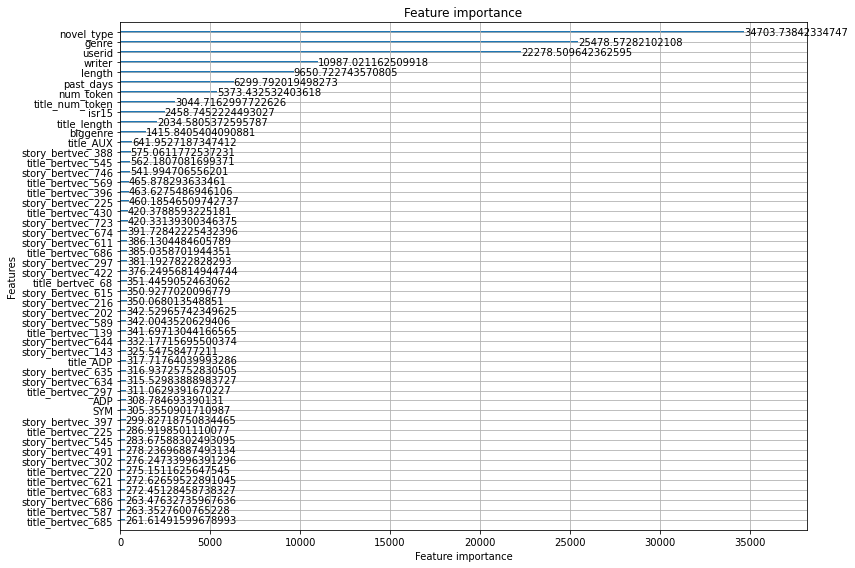

In [ ]:
# 特徴量の重要度を確認

lgb.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()

In [ ]:
# 評価指標はlog lossだが、accuracyも見てみる

val_pred = model.predict(val_x, num_iteration=model.best_iteration)
val_pred_max = np.argmax(val_pred, axis=1)  # 最尤と判断したクラスの値にする
accuracy = sum(val_y == val_pred_max) / len(val_y)
print(accuracy)

0.6458


### 推論・投稿ファイル作成

In [ ]:
test_pred = model.predict(test_x, num_iteration=model.best_iteration)

In [ ]:
sub_df.iloc[:, 1:] = test_pred

In [ ]:
sub_df.to_csv('../output/test_submission.csv', index=False)